<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/EfficientNetb4_ExtraConvLayer_DropoutTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective of Notebook
### This notebook explores fine-tuning a custom EfficientNet-B4 model with additional convolutional layers and dropout on the Flowers102 dataset. Through hyperparameter tuning, we optimize the dropout rates for the extra convolutional and classifier layers to achieve the best validation accuracy. After selecting the optimal dropout configuration, the model is retrained and evaluated on test dataset.

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=7ae2d278aee81e588ed8bf003af818725a8c5d6f07826a43069afcf138705b54
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
# necessary imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torch.cuda.amp import autocast, GradScaler

In [ ]:
# apply transformations to the images
transform = transforms.Compose([
    # resize image to 224x224
    transforms.Resize((224, 224)),
    
    # convert image to tensor
    transforms.ToTensor(),
    
    # normalize image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# load training data
train_data = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)

# load validation data
val_data = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)

# load test data
test_data = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)

100%|██████████| 345M/345M [00:10<00:00, 33.0MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 751kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 19.9MB/s]


In [ ]:
# create dataloader for training data with batch size 32 and shuffle enabled
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# create dataloader for validation data with batch size 32 and shuffle disabled
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# create dataloader for test data with batch size 32 and shuffle disabled
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

### This custom model extends EfficientNet-B4 by adding additional convolutional layers and a modified classifier tailored for the 102-class Flowers102 dataset. After EfficientNet-B4 processes the input, its 1792-channel output is passed through extra convolutional layers (with batch normalization, ReLU activations, and dropout) to enhance feature extraction. An adaptive average pooling layer reduces the features to a single 1x1 vector, which then goes through a fully connected layer, dropout for regularization, and a final layer producing the 102-class predictions. This structure leverages EfficientNet’s pre-trained features while enhancing model capacity to better adapt to the specific dataset.

In [ ]:
# define custom model class that extends nn.Module
class CustomEfficientNet(nn.Module):
    # constructor to initialize the model
    def __init__(self, dropout_extra_conv=0.3, dropout_classifier=0.3):
        # initialize the parent class (nn.Module)
        super(CustomEfficientNet, self).__init__()
        
        # load the pre-trained EfficientNet-B4 model
        self.base_model = EfficientNet.from_pretrained('efficientnet-b4')

        # define additional convolutional layers to further process the features
        self.extra_conv = nn.Sequential(
            # first convolutional layer with 1792 input channels (output from EfficientNet) and 2048 output channels
            nn.Conv2d(1792, 2048, kernel_size=3, padding=1),
            # batch normalization to stabilize training
            nn.BatchNorm2d(2048),
            # ReLU activation to introduce non-linearity
            nn.ReLU(),
            # second convolutional layer with 2048 input and output channels
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            # batch normalization for the second convolutional layer
            nn.BatchNorm2d(2048),
            # ReLU activation
            nn.ReLU(),
            # dropout layer to prevent overfitting, applied to the additional convolution layers
            nn.Dropout(dropout_extra_conv)
        )

        # define the classifier section to output the final prediction
        num_ftrs = 2048  # number of input features to the classifier after the extra convolution layers
        self.classifier = nn.Sequential(
            # adaptive average pooling to resize the feature map to (1, 1), creating a single vector per image
            nn.AdaptiveAvgPool2d((1, 1)),
            # flatten the output to turn it into a 1D vector
            nn.Flatten(),
            # fully connected layer with 2048 input features and 512 output features
            nn.Linear(num_ftrs, 512),
            # ReLU activation for the fully connected layer
            nn.ReLU(),
            # dropout layer to prevent overfitting, applied to the classifier
            nn.Dropout(dropout_classifier),
            # final fully connected layer to output predictions (102 classes for the Flowers102 dataset)
            nn.Linear(512, 102)
        )

    # forward pass to process the input through the model
    def forward(self, x):
        # pass the input through the pre-trained EfficientNet feature extractor
        x = self.base_model.extract_features(x)
        # pass the output of the base model through the additional convolution layers
        x = self.extra_conv(x)
        # pass the output through the classifier to get final predictions
        x = self.classifier(x)
        return x


In [ ]:
# set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# initialize a gradient scaler for mixed precision training to improve performance and reduce memory usage
scaler = GradScaler()

<ipython-input-8-9f6a838c5572>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
def train_model(model, dataloader, criterion, optimizer, device):
    # set the model to training mode
    model.train()
    
    # initialize variables for tracking loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0
    
    # loop over the data in the dataloader
    for inputs, labels in dataloader:
        # move inputs and labels to the specified device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the gradients to avoid accumulation from previous steps
        optimizer.zero_grad()

        # use autocast for mixed precision training
        with autocast():
            # forward pass: get model outputs
            outputs = model(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)

        # scale the loss and backpropagate
        scaler.scale(loss).backward()
        # update the model parameters
        scaler.step(optimizer)
        # update the scaler for next iteration
        scaler.update()

        # accumulate the running loss
        running_loss += loss.item()
        # get the predicted class with the highest probability
        _, predicted = torch.max(outputs, 1)
        # track the total number of samples
        total += labels.size(0)
        # count how many predictions are correct
        correct += (predicted == labels).sum().item()
    
    # return the average loss and accuracy for the epoch
    return running_loss / len(dataloader), correct / total


In [ ]:
def validate_model(model, dataloader, criterion, device):
    # set the model to evaluation mode
    model.eval()
    
    # initialize variables for tracking loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0
    
    # disable gradient calculation for validation 
    with torch.no_grad():
        # loop over the data in the dataloader
        for inputs, labels in dataloader:
            # move inputs and labels to the specified device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # forward pass: get model outputs
            outputs = model(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)
            
            # accumulate the running loss
            running_loss += loss.item()
            # get the predicted class with the highest probability
            _, predicted = torch.max(outputs, 1)
            # track the total number of samples
            total += labels.size(0)
            # count how many predictions are correct
            correct += (predicted == labels).sum().item()

    # return the average loss and accuracy for the validation set
    return running_loss / len(dataloader), correct / total


In [ ]:
def test_model(model, dataloader, device):
    # set the model to evaluation mode
    model.eval()
    
    # initialize variables to track accuracy
    correct = 0
    total = 0
    
    # disable gradient calculation for testing 
    with torch.no_grad():
        # loop over the data in the dataloader
        for inputs, labels in dataloader:
            # move inputs and labels to the specified device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # forward pass: get model outputs
            outputs = model(inputs)
            # get the predicted class with the highest probability
            _, predicted = torch.max(outputs, 1)
            # track the total number of samples
            total += labels.size(0)
            # count how many predictions are correct
            correct += (predicted == labels).sum().item()

    # return the overall accuracy for the test set
    return correct / total

In [ ]:
# list of dropout values to tune for both the extra convolutional layers and classifier
dropout_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
num_epochs = 100  # set the number of training epochs
patience = 5  # set the number of epochs without improvement before early stopping
best_val_acc = 0.0  # track the best validation accuracy across all configurations
best_model_config = None  # track the best dropout configuration
criterion = nn.CrossEntropyLoss()  # use crossentropyloss as the loss function

# loop through all the dropout values to tune the model
for dropout_rate in dropout_values:
    print(f"tuning dropout: extra_conv={dropout_rate}, classifier={dropout_rate}")

    # create a new model instance with the current dropout rates for both extra_conv and classifier
    model = CustomEfficientNet(dropout_extra_conv=dropout_rate, dropout_classifier=dropout_rate).to(device)
    # use adam optimizer with a learning rate of 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # initialize variables to track early stopping and best validation accuracy for this configuration
    counter = 0  # counter for the number of epochs without improvement
    best_val_acc_current = 0.0  # track the best validation accuracy for the current dropout configuration

    # train and validate the model for the specified number of epochs
    for epoch in range(num_epochs):
        # train the model and get the loss and accuracy for the training set
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        # validate the model and get the loss and accuracy for the validation set
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        # print training and validation statistics for the current epoch
        print(f"epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}, validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")

        # if the validation accuracy has improved, reset the counter and update the best accuracy for this configuration
        if val_acc > best_val_acc_current:
            best_val_acc_current = val_acc
            counter = 0
        else:
            # if validation accuracy didn't improve, increment the counter
            counter += 1

        # if we have reached the patience limit (no improvement for 'patience' epochs), stop training early
        if counter >= patience:
            print(f"early stopping at epoch {epoch+1}. no improvement in validation accuracy for {patience} consecutive epochs.")
            break

    # after training the model for the current dropout configuration, check if it gave the best validation accuracy
    if best_val_acc_current > best_val_acc:
        best_val_acc = best_val_acc_current  # update the best validation accuracy
        best_model_config = dropout_rate  # store the best dropout configuration

# after tuning all dropout configurations, print the best configuration and its validation accuracy
print(f"best dropout configuration: extra_conv={best_model_config}, classifier={best_model_config}")
print(f"best validation accuracy during tuning: {best_val_acc:.4f}")

# store the best dropout configuration for further use
best_dropout = best_model_config


Tuning dropout: extra_conv=0, classifier=0


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 183MB/s]


Loaded pretrained weights for efficientnet-b4


<ipython-input-9-de5e9a8c4504>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/100], Train Loss: 4.4269, Train Accuracy: 0.0559, Validation Loss: 4.6410, Validation Accuracy: 0.0490
Epoch [2/100], Train Loss: 3.2409, Train Accuracy: 0.1892, Validation Loss: 3.4498, Validation Accuracy: 0.2196
Epoch [3/100], Train Loss: 2.2548, Train Accuracy: 0.3882, Validation Loss: 3.0555, Validation Accuracy: 0.3069
Epoch [4/100], Train Loss: 1.5446, Train Accuracy: 0.5363, Validation Loss: 2.4997, Validation Accuracy: 0.4549
Epoch [5/100], Train Loss: 1.1555, Train Accuracy: 0.6578, Validation Loss: 2.4834, Validation Accuracy: 0.4490
Epoch [6/100], Train Loss: 0.9422, Train Accuracy: 0.7304, Validation Loss: 2.3720, Validation Accuracy: 0.5167
Epoch [7/100], Train Loss: 0.7528, Train Accuracy: 0.7784, Validation Loss: 1.5213, Validation Accuracy: 0.6490
Epoch [8/100], Train Loss: 0.5654, Train Accuracy: 0.8294, Validation Loss: 1.6994, Validation Accuracy: 0.6284
Epoch [9/100], Train Loss: 0.4331, Train Accuracy: 0.8647, Validation Loss: 1.6652, Validation Accuracy:

In [ ]:
# create a new model with the best dropout values and move it to the device (GPU/CPU)
model = CustomEfficientNet(dropout_extra_conv=best_dropout, dropout_classifier=best_dropout).to(device)
# initialize the optimizer (Adam) with a learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# initialize lists to store loss and accuracy histories for training and validation
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_val_acc = 0.0  # track the best validation accuracy
counter = 0  # counter to track epochs without improvement

# retrain the model for the specified number of epochs
for epoch in range(num_epochs):
    # train the model and get the loss and accuracy for the training set
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    # validate the model and get the loss and accuracy for the validation set
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)

    # store the training and validation losses and accuracies in their respective lists
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # print statistics for the current epoch
    print(f"retrain epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}, validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")

    # if the validation accuracy has improved, update the best accuracy and save the model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'Best_EfficientNetb4_ExtraConv_DropoutTuned.pth')
        counter = 0  # reset the counter since the accuracy improved
    else:
        # increment the counter if no improvement in validation accuracy
        counter += 1

    # stop training early if no improvement in validation accuracy for 'patience' epochs
    if counter >= patience:
        print(f"early stopping at epoch {epoch+1} during retraining. no improvement in validation accuracy for {patience} consecutive epochs.")
        break

# store the final results (training and validation losses and accuracies)
final_results = {
    "train_loss": train_loss_history,
    "train_acc": train_acc_history,
    "val_loss": val_loss_history,
    "val_acc": val_acc_history
}


Loaded pretrained weights for efficientnet-b4


<ipython-input-9-de5e9a8c4504>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Retrain Epoch [1/100], Train Loss: 4.4851, Train Accuracy: 0.0441, Validation Loss: 3.9043, Validation Accuracy: 0.0902
Retrain Epoch [2/100], Train Loss: 3.2870, Train Accuracy: 0.1814, Validation Loss: 3.4124, Validation Accuracy: 0.2078
Retrain Epoch [3/100], Train Loss: 2.5111, Train Accuracy: 0.2951, Validation Loss: 3.0681, Validation Accuracy: 0.3127
Retrain Epoch [4/100], Train Loss: 1.9015, Train Accuracy: 0.4588, Validation Loss: 3.1298, Validation Accuracy: 0.3069
Retrain Epoch [5/100], Train Loss: 1.4811, Train Accuracy: 0.5686, Validation Loss: 1.6785, Validation Accuracy: 0.5539
Retrain Epoch [6/100], Train Loss: 1.1434, Train Accuracy: 0.6402, Validation Loss: 1.6112, Validation Accuracy: 0.5853
Retrain Epoch [7/100], Train Loss: 0.9075, Train Accuracy: 0.7314, Validation Loss: 2.1415, Validation Accuracy: 0.5431
Retrain Epoch [8/100], Train Loss: 0.7436, Train Accuracy: 0.7824, Validation Loss: 1.9487, Validation Accuracy: 0.6108
Retrain Epoch [9/100], Train Loss: 0.584

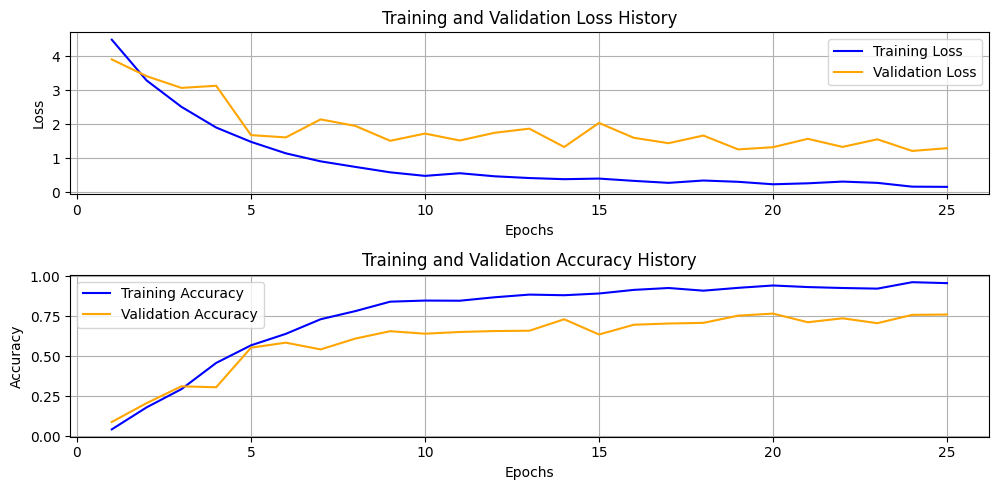

In [ ]:
# cell for plotting training and validation metrics
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# create a new model with the best dropout values
model = CustomEfficientNet(dropout_extra_conv=best_dropout, dropout_classifier=best_dropout)
model.to(device)
# load the saved model weights from the best checkpoint
model.load_state_dict(torch.load('Best_EfficientNetb4_ExtraConv_DropoutTuned.pth'))
# evaluate the model on the test data 
test_acc = test_model(model, test_loader, device)
print(f"test accuracy: {test_acc:.4f}")

Loaded pretrained weights for efficientnet-b4


<ipython-input-19-fe082bf58fae>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Best_EfficientNetb4_ExtraConv_DropoutTuned.pth'))


Test Accuracy: 0.7209


## Analysis of Results
### The training loss and accuracy steadily improve, while validation metrics plateau around epoch 15, indicating limited further gains. The final test accuracy of 0.7209 closely matches validation accuracy, suggesting reasonable generalization despite minor overfitting. The tuned dropout settings moderately helped, but further regularization may still be beneficial.